In [1]:
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import copy

In [2]:
# ------------------------------------------------------------
# 1. Read in the network link list
# ------------------------------------------------------------
# The file `Link_list.csv` contains the toy N-D network definition:
#   - Link: link ID
#   - From, To: start/end node IDs
#   - Capacity: initial link capacities (s_i,0)
#   - Link Cost: uncongested generalized cost t_i
#
# This corresponds to the network setup described in Section 2.2 
# of the paper (Problem Description, Eq. (1)-(4)).
# ------------------------------------------------------------
Link_list = pd.read_csv('Link_list.csv')
Link_list

,Link,From,To,Link Cost,Capacity,Link Type
0,1,1,5,7.00,999999,Walk
1,2,1,12,9.00,999999,Walk
2,3,4,5,9.00,999999,Walk
3,4,4,9,12.00,999999,Walk
4,5,5,6,3.00,999999,Walk
5,6,5,9,9.00,999999,Walk
6,7,6,7,5.00,999999,Walk
7,8,6,10,13.00,999999,Walk
8,9,7,8,5.00,999999,Walk
9,10,7,11,9.00,999999,Walk


In [4]:
# ------------------------------------------------------------
# 2. Build link-node matrix
# ------------------------------------------------------------
# Assemble an array [Link, From, To, Capacity] for each link.
# If capacity is coded as 999999 in the CSV, replace with np.inf 
# (i.e., uncapacitated link such as walking connections).
# ------------------------------------------------------------
Link = Link_list['Link'].to_numpy()
From = Link_list['From'].to_numpy()
To   = Link_list[ 'To' ].to_numpy()
Capacity = Link_list['Capacity'].to_numpy()

link_node = np.vstack((Link,From))
link_node = np.vstack((link_node,To))
link_node = np.vstack((link_node, Capacity))
link_node = link_node.T

link_node = link_node.astype('float')

for i in range(link_node.shape[0]):
    if link_node[i,3] == 999999:
        link_node[i,3] = np.inf

s0 = link_node[:,3]

Link = Link_list['Link'].to_numpy()
From = Link_list['From'].to_numpy()
To = Link_list['To'].to_numpy()
Capacity = Link_list['Capacity'].to_numpy()

link_node = np.vstack((Link,From))
link_node = np.vstack((link_node,To))
link_node = np.vstack((link_node,Capacity))
link_node = link_node.T 
link_node


array([[     1,      1,      5, 999999],
       [     2,      1,     12, 999999],
       [     3,      4,      5, 999999],
       [     4,      4,      9, 999999],
       [     5,      5,      6, 999999],
       [     6,      5,      9, 999999],
       [     7,      6,      7, 999999],
       [     8,      6,     10, 999999],
       [     9,      7,      8, 999999],
       [    10,      7,     11, 999999],
       [    11,      8,      2, 999999],
       [    12,      9,     10, 999999],
       [    13,      9,     13, 999999],
       [    14,     10,     11, 999999],
       [    15,     11,      2, 999999],
       [    16,     11,      3, 999999],
       [    17,     12,      6, 999999],
       [    18,     12,      8, 999999],
       [    19,     13,      3, 999999],
       [    20,     18,     19, 999999],
       [    21,     18,     20, 999999],
       [    22,     18,     22, 999999],
       [    23,     18,     23, 999999],
       [    24,     18,     24, 999999],
       [    25, 

In [5]:
# ------------------------------------------------------------
# 3. Build adjacency dictionary N
# ------------------------------------------------------------
# N[i] = list of successor nodes from node i
# Used later for path generation (Algorithm 1).
# ------------------------------------------------------------
N = {}
for i in range(max(From)):
    N[i+1] = []
for i in range(len(link_node)):
    N[link_node[i,1]].append(link_node[i,2])

In [6]:
# ------------------------------------------------------------
# 4. Define OD pairs and travel demand r
# ------------------------------------------------------------
# OD pairs: (1,2), (1,3), (4,2), (4,3)
# Demands: 400, 800, 600, 200 (respectively)
# This defines vector r (Eq. (7) demand constraint).
# ------------------------------------------------------------
O = np.array([1,1,4,4])
D = np.array([2,3,2,3])

r = np.array([400,800,600,200])

t_link = Link_list['Link Cost'].to_numpy()

In [7]:
# ------------------------------------------------------------
# 5. Generate cost adjacency matrix c_int
# ------------------------------------------------------------
# Initialize c_int with ∞ except diagonal = 0.
# Fill with uncongested link costs.
# This is used to compute initial shortest paths.
# ------------------------------------------------------------
c_int = np.ones((len(N),len(N))) * np.inf
for i in range(len(N)):
    c_int[i,i] = 0
for i in range(len(link_node)):
    link_id = link_node[i,0]
    start = link_node[i,1]
    end = link_node[i,2]
    if c_int[int(start) - 1, int(end) - 1] > t_link[int(link_id)-1]:
        c_int[int(start) - 1, int(end) - 1] = t_link[int(link_id)-1]
        
        
# ------------------------------------------------------------
# 6. Example subset of nodes (Uber-specific experiment)
# ------------------------------------------------------------
UBER_NODES = [18,19,20,21,22,23,24]

In [8]:
# ------------------------------------------------------------
# 7. Define Flow-Capacity Interaction matrix F
# ------------------------------------------------------------
# F[i,k] represents efficiency p_ik: the contribution of flow on link k 
# to the capacity of link i (Eq. (1)-(3)).
#
# - Negative values: flow consumes capacity on another link.
# - Positive values: flow adds to capacity (e.g., drop-offs or rebalancing).
# 
# This F encodes assumed relationships for the toy network example 
# (Section 3 Numerical Example).
# ------------------------------------------------------------
F = np.zeros((54,54))

F[41-1,40-1] = -0.1
F[42-1,40-1] = 0.1

F[43-1,(37-1):(39)]= -0.1
F[44-1,(37-1):(39)]= -0.1

F[46-1,(25-1):(28)]= -0.1
F[45-1,(20-1):(24)]= -0.1
F[47-1,(29-1):(31)]= -0.1
F[49-1,(34-1):(36)]= -0.1
F[51-1,(32-1):(33)]= -0.1

F[47-1,22-1] = 0.1
F[47-1,27-1] = 0.1
F[49-1,24-1] = 0.1h6u8t6u
F[51-1,23-1] = 0.1
F[51-1,28-1] = 0.1
F[51-1,31-1] = 0.1
F[51-1,36-1] = 0.1

###########
BOUNDED CRITERION:  3.5
----- OD  1  -----
3.5
--- OD  1  finished ---
[ 8.8  14.4  16.6  22.3  24.05 24.8  26.5  28.25 28.8  29.   29.  ]
(54, 11)
----- OD  2  -----
3.5
--- OD  2  finished ---
[ 9.4  15.   17.8  22.1  23.85 24.6  25.5  27.25 28.   28.6  32.  ]
(54, 11)
----- OD  3  -----
3.5
--- OD  3  finished ---
[ 9.2 16.4 24.3 26.8 28.5 30.8 31.  31. ]
(54, 8)
----- OD  4  -----
3.5
--- OD  4  finished ---
[ 9.4 17.  24.1 26.6 27.5 30.  30.6 32.  32.6]
(54, 9)
Academic license - for non-commercial use only - expires 2025-10-29
Using license file /Users/bingqing/gurobi.lic
Model feasible!
---- Initial h: [1.0000000e-05 1.0000000e-05 1.0000000e-05 1.0000000e-05 1.0000000e-05
 1.0000000e-05 1.0000000e-05 1.0000000e-05 1.0000000e-05 1.0000000e-05
 3.9999990e+02 1.0000000e-05 1.0000000e-05 1.0000000e-05 1.0000000e-05
 1.0000000e-05 1.0000000e-05 1.0000000e-05 1.0000000e-05 1.0000000e-05
 1.0000000e-05 7.9999990e+02 1.0000000e-05 1.0000000e-05 1.0000000e-05
 1.0000000e-05 1

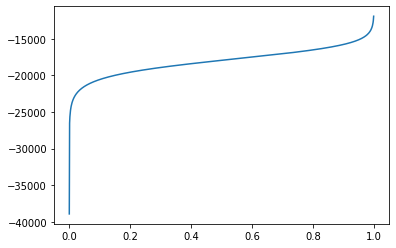

---- Alpha: 1
ERROR: 994.8625523739582
iter time: 0.19776320457458496 sec
############ Iter 1 ############
---- Alpha: 0.1846177577972412
ERROR: 181.5094951323243
iter time: 0.05464601516723633 sec
############ Iter 2 ############
---- Alpha: 0.24762248992919922
ERROR: 163.46685037037594
iter time: 0.051254987716674805 sec
############ Iter 3 ############
---- Alpha: 0.14710187911987305
ERROR: 67.45564792427149
iter time: 0.05051088333129883 sec
############ Iter 4 ############
---- Alpha: 0.012338519096374512
ERROR: 6.492939478050543
iter time: 0.04874396324157715 sec
############ Iter 5 ############
---- Alpha: 0.15142202377319336
ERROR: 64.68564395907262
iter time: 0.050914764404296875 sec
############ Iter 6 ############
---- Alpha: 0.07035493850708008
ERROR: 30.6478744933911
iter time: 0.04845905303955078 sec
############ Iter 7 ############
---- Alpha: 0.18542957305908203
ERROR: 69.78910178808883
iter time: 0.05070185661315918 sec
############ Iter 8 ############
---- Alpha: 0.06

---- Alpha: 0.004769325256347656
ERROR: 1.5819019792821283
iter time: 0.04762697219848633 sec
############ Iter 67 ############
---- Alpha: 0.0003000497817993164
ERROR: 0.26306799911483914
## Consecu iteration =  1 ##
iter time: 0.049942970275878906 sec
############ Iter 68 ############
---- Alpha: 0.0028772354125976562
ERROR: 1.2074335785971224
iter time: 0.050339698791503906 sec
############ Iter 69 ############
---- Alpha: 0.0065460205078125
ERROR: 2.6326893207885402
iter time: 0.0511319637298584 sec
############ Iter 70 ############
---- Alpha: 0.000266343355178833
ERROR: 0.15461755160370863
## Consecu iteration =  1 ##
iter time: 0.05305886268615723 sec
############ Iter 71 ############
---- Alpha: 0.005049705505371094
ERROR: 2.2611840699806325
iter time: 0.05515599250793457 sec
############ Iter 72 ############
---- Alpha: 0.0018749237060546875
ERROR: 0.6383091474093843
iter time: 0.05623221397399902 sec
############ Iter 73 ############
---- Alpha: 0.004164218902587891
ERROR: 1.

---- Alpha: 0.002517223358154297
ERROR: 1.2873258659127744
iter time: 0.04943108558654785 sec
############ Iter 131 ############
---- Alpha: 0.0020742416381835938
ERROR: 0.7439401820464047
iter time: 0.05164909362792969 sec
############ Iter 132 ############
---- Alpha: 0.0006593465805053711
ERROR: 0.19660482774856805
## Consecu iteration =  1 ##
iter time: 0.04795694351196289 sec
############ Iter 133 ############
---- Alpha: 0.0031309127807617188
ERROR: 0.7918980383520151
iter time: 0.04770088195800781 sec
############ Iter 134 ############
---- Alpha: 0.0007023811340332031
ERROR: 0.4645530021522946
## Consecu iteration =  1 ##
iter time: 0.0479741096496582 sec
############ Iter 135 ############
---- Alpha: 0.002338409423828125
ERROR: 0.6635753785308178
iter time: 0.050559043884277344 sec
############ Iter 136 ############
---- Alpha: 0.0018153190612792969
ERROR: 1.0590184180644526
iter time: 0.04821038246154785 sec
############ Iter 137 ############
---- Alpha: 0.0026712417602539062

---- Alpha: 0.004319190979003906
ERROR: 1.567499440653528
iter time: 0.04814291000366211 sec
############ Iter 193 ############
---- Alpha: 0.0008935928344726562
ERROR: 0.48850038329554857
## Consecu iteration =  1 ##
iter time: 0.05102682113647461 sec
############ Iter 194 ############
---- Alpha: 0.0024166107177734375
ERROR: 0.8178056124075509
iter time: 0.04834413528442383 sec
############ Iter 195 ############
---- Alpha: 0.00067901611328125
ERROR: 0.4945886883966968
## Consecu iteration =  1 ##
iter time: 0.04871487617492676 sec
############ Iter 196 ############
---- Alpha: 0.0009315013885498047
ERROR: 0.393781337980926
## Consecu iteration =  2 ##
iter time: 0.049689292907714844 sec
############ Iter 197 ############
---- Alpha: 0.0016040802001953125
ERROR: 0.5648649935358476
iter time: 0.047564029693603516 sec
############ Iter 198 ############
---- Alpha: 0.002205371856689453
ERROR: 1.011659106596629
iter time: 0.05149102210998535 sec
############ Iter 199 ############
---- Al

---- Alpha: 0.0023517608642578125
ERROR: 0.7206910716331434
iter time: 0.06226468086242676 sec
############ Iter 253 ############
---- Alpha: 0.0004366636276245117
ERROR: 0.23164446311746
## Consecu iteration =  1 ##
iter time: 0.0830831527709961 sec
############ Iter 254 ############
---- Alpha: 0.0010600090026855469
ERROR: 0.44729032607520613
iter time: 0.08057785034179688 sec
############ Iter 255 ############
---- Alpha: 0.0009026527404785156
ERROR: 0.35473172929120805
## Consecu iteration =  1 ##
iter time: 0.062072038650512695 sec
############ Iter 256 ############
---- Alpha: 0.0026578903198242188
ERROR: 1.0381887835424368
iter time: 0.06253695487976074 sec
############ Iter 257 ############
---- Alpha: 0.0007655620574951172
ERROR: 0.35954698227162496
## Consecu iteration =  1 ##
iter time: 0.05295681953430176 sec
############ Iter 258 ############
---- Alpha: 0.001314401626586914
ERROR: 0.49311264411937933
iter time: 0.05374002456665039 sec
############ Iter 259 ############
--

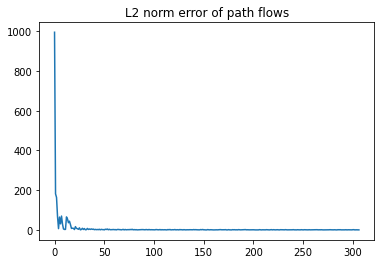

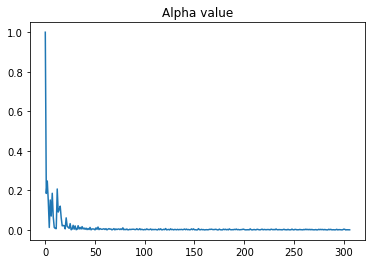

Total time: 16.589125871658325 sec
CPU times: user 18.6 s, sys: 966 ms, total: 19.5 s
Wall time: 19.1 s


In [10]:
%%time

from k_path_finding import k_path_finding
from FW_SUECC import FW_SUECC, find_nearest, binary_search

done_OD = 0
maxitr = 5000
verbose = 0

alpha = 1
b = 3.5

num_path_set = []
obj_set = []
total_t_set = []
h_UE_set = []
cap_set = []
link_flow_set = [] 
lm_set = []
d_set = []
delayed_time_set = []

print("###########")
print("BOUNDED CRITERION: ",b)
A_set = {1: [],
     2: [],
     3: [],
     4: []}
for i in range(len(O)):
    done_OD = 0
    A, t_path ,bbb= k_path_finding(i,done_OD, b, [O[i]],[D[i]], r,N,link_node,c_int,t_link,UBER_NODES)
    print(t_path)
    A_set[i+1].append(A)
    print(A.shape)

A = np.hstack((A_set[1][0],A_set[2][0]))
A = np.hstack((A,A_set[3][0]))
A = np.hstack((A,A_set[4][0]))

B_set = {1:[],
         2:[],
         3:[],
         4:[]}

for K in range(4):
    B = np.zeros((4,A_set[K+1][0].shape[1]))
    size = A_set[K+1][0].shape[1]
    for j in range(size):
        B[K,j] = 1
    B_set[K+1].append(B)

B = np.hstack((B_set[1][0],B_set[2][0]))
B = np.hstack((B,B_set[3][0]))
B = np.hstack((B,B_set[4][0]))

G = np.dot((F - np.eye(len(link_node))),A)
t_path = np.dot(A.T,t_link)

e = 10**(-3)
tolerance = 0.001
tau = 10**(-5)
PRINT = 1
consecu_iter = 5

h_opt,v_opt = FW_SUECC(e,tolerance,tau,consecu_iter,alpha,
                       t_link,t_path,A,B,G,r,s0,PRINT)

obj = sum(np.multiply((np.log(h_opt)-1),h_opt))+alpha*np.dot(t_path,h_opt)
total_t = np.dot(t_path,h_opt)
cap = np.dot(F, np.dot(A, h_opt))+s0

num_path_set.append(len(t_path))
obj_set.append(obj)
total_t_set.append(total_t)
h_UE_set.append(h_opt) 
cap_set.append(cap) 
link_flow_set.append(v_opt) 
#     lm_set.append(lm)
#     d_set.append(d)
#     delayed_time_set.append(delayed_time)
    